Object Detection API and retraining [RetinaNet](https://arxiv.org/abs/1708.02002) to spot cars using just a few training images. 



## Installation

First let's install the Tensorflow 2 [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection).

In [ ]:
# uncomment the next line if you want to delete an existing models directory
!rm -rf ./models/

# clone the Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

Cloning into 'models'...
remote: Enumerating objects: 3308, done.
remote: Counting objects: 100% (3308/3308), done.
remote: Compressing objects: 100% (2729/2729), done.
remote: Total 3308 (delta 877), reused 1389 (delta 530), pack-reused 0
Receiving objects: 100% (3308/3308), 34.29 MiB | 20.76 MiB/s, done.
Resolving deltas: 100% (877/877), done.


In [ ]:
# Compile the Object Detection API protocol buffers
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

Will write a file based on the [setup script](https://github.com/tensorflow/models/blob/master/research/object_detection/packages/tf2/setup.py) in the official repo to work with the packages in the current version of Colab.

In [ ]:
%%writefile models/research/setup.py

import os
from setuptools import find_packages
from setuptools import setup

REQUIRED_PACKAGES = [
    'tf-models-official==2.8.0',
    'tensorflow_io'
]

setup(
    name='object_detection',
    version='0.1',
    install_requires=REQUIRED_PACKAGES,
    include_package_data=True,
    packages=(
        [p for p in find_packages() if p.startswith('object_detection')] +
        find_packages(where=os.path.join('.', 'slim'))),
    package_dir={
        'datasets': os.path.join('slim', 'datasets'),
        'nets': os.path.join('slim', 'nets'),
        'preprocessing': os.path.join('slim', 'preprocessing'),
        'deployment': os.path.join('slim', 'deployment'),
        'scripts': os.path.join('slim', 'scripts'),
    },
    description='Tensorflow Object Detection Library',
    python_requires='>3.6',
)

Writing models/research/setup.py


In [ ]:
# Run the setup script we just wrote
!python -m pip install models/research

## Imports

Let's now import the packages we will use in this project.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import scipy.misc
import numpy as np

#import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
#from IPython.display import display, Javascript
#from IPython.display import Image as IPyImage


try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

##Import Object Detection API packages

Let's the necessary modules from the `object_detection` package. 
- From the [utils](https://github.com/tensorflow/models/tree/master/research/object_detection/utils) package:
  - [label_map_util](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/label_map_util.py)
  - [config_util](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/config_util.py): We'll use this to read model configurations from a .config file and then modify that configuration
  - [visualization_utils](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py): this is given the alias `viz_utils`.
  - [colab_utils](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/colab_utils.py)
- From the [builders](https://github.com/tensorflow/models/tree/master/research/object_detection/builders) package:
  - [model_builder](https://github.com/tensorflow/models/blob/master/research/object_detection/builders/model_builder.py): This builds the model according to the model configuration that we'll specify.

In [ ]:
# import the label map utility module
from object_detection.utils import label_map_util

# import module for reading and updating configuration files.
from object_detection.utils import config_util

# import module for visualization using the alias `viz_utils`
from object_detection.utils import visualization_utils as viz_utils

# import module for building the detection model
from object_detection.builders import model_builder

# import module for utilities in Colab
from object_detection.utils import colab_utils

Let's now define a couple of utility functions for loading images and plotting detections.

In [ ]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(20, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """
    
    image_np_with_annotations = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.6)
    
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    
    else:
        plt.imshow(image_np_with_annotations)


##Upload the training images to Colab

In [ ]:
#upload images of cars to directory (in our case using colab)
from google.colab import files
uploaded = files.upload()


Saving car_1.jpg to car_1.jpg
Saving car_2.jpg to car_2.jpg
Saving car_3.jpg to car_3.jpg
Saving car_4.jpg to car_4.jpg
Saving car_5.jpg to car_5.jpg
Saving car_6.jpg to car_6.jpg


Visualize the training images

Let's inspect the images placed in folder '/content/' in Colab. 
We see the 6 training images after running this cell. 

/content/car_1.jpg
/content/car_2.jpg
/content/car_3.jpg
/content/car_4.jpg
/content/car_5.jpg
/content/car_6.jpg


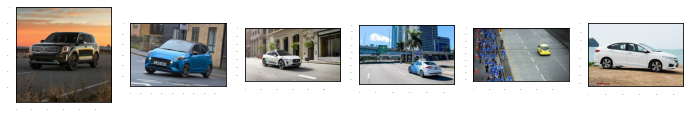

In [ ]:
%matplotlib inline

# assign the name (string) of the directory containing the training images
train_image_dir = '/content/'
# declare an empty list
train_images_np = []

# run a for loop for each image
for i in range(1, 7):

    # define the path (string) for each image
    image_path = os.path.join(train_image_dir+'car_'+str(i)+'.jpg')
    print(image_path)

    # load images into numpy arrays and append to a list
    train_images_np.append(load_image_into_numpy_array(image_path))
  

# configure plot settings via rcParams
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# plot images
for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(1, 7, idx+1)
  plt.imshow(train_image_np)
  
plt.show()

<a name='gt_boxes_definition'></a>
## Prepare data for training

Create the ground truth boxes.

In [ ]:
# Define the list of ground truth boxes
gt_boxes = []

* Draw a box around the car in each image. 
* Click the `next image` button to go to the next image
* Click `submit` when it says "All images completed!!". 

- Make sure to not make the bounding box too big. 
  - If the box is too big, the model might learn the features of the background.
- Include the entire car inside the box. 


In [ ]:

# annotate the training images; I have commented this line because further
# down I am providing the coordinates as an array to make the process faster
colab_utils.annotate(train_images_np, box_storage_pointer= gt_boxes )


Let's view the ground truth box coordinates


In [ ]:
# print the coordinates of the ground truth boxes
for gt_box in gt_boxes:
  print(gt_box)
print(gt_boxes)

#gt_boxes coordinates already annotated previously to speed up the process
gt_boxes =np.array([[[0.25440104, 0.12333333, 0.65606771, 0.87166667]], 
           [[0.25773438, 0.14555556, 0.87273438, 0.86444444]], 
           [[0.41273437, 0.17333333, 0.78773437, 0.5925    ]], 
           [[0.59940104, 0.48763251, 0.88773437, 0.87279152]], 
           [[0.31106771, 0.65      , 0.53106771, 0.80666667]], 
           [[0.29773437, 0.04710145, 0.77773437, 0.94202899]]])

print(gt_boxes)

Now let's add the class annotations. In this case we consider a single class, though it can be extended this to handle multiple classes. Also we convert everything to the format that the training loop expects (e.g., conversion to tensors, one-hot representations, etc.).

### Define the category index dictionary

We need to tell the model which integer class ID to assign to the 'car' category, and what 'name' to associate with that integer id.

- car_class_id: By convention, class ID integers start numbering from 1,2,3, onward.
  - If there is ever a 'background' class, it could be assigned the integer 0, but in this case, we are just predicting the one 'car' class.
  - Since we are just predicting one class, we assign `1` to the car class ID.

- category_index: We define the `category_index` dictionary

- num_classes: Since we are predicting one class, we assign `1` to the number of classes that the model will predict.
  

In [ ]:
# Assign the car class ID
car_class_id = 1

# define a dictionary describing the car class
category_index = {car_class_id:{ 'id': car_class_id, 'name': 'car'}}

# Specify the number of classes that the model will predict
num_classes =1


### Data preprocessing
We will now do some data preprocessing so it is formatted properly before it is fed to the model:
- Convert the class labels to one-hot representations
- convert everything (i.e. train images, gt boxes and class labels) to tensors.

In [ ]:
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in the training binaries, but we need to reproduce it here.

label_id_offset = 1
train_image_tensors=[]

# lists containing the one-hot encoded classes and ground truth boxes
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    
    # convert training image to tensor, add batch dimension, and add to list
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        train_image_np, dtype=tf.float32), axis=0))
    
    # convert numpy array to tensor, then add to list
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype = tf.float32))
    
    # apply offset to have zero-indexed ground truth classes
    zero_indexed_ground_truth_classes = tf.convert_to_tensor(
        np.ones(shape = [gt_box_np.shape[0]], dtype = np.int32)-label_id_offset)
 
    # do one-hot encoding to ground truth classes
    gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_ground_truth_classes,
                                                 num_classes))

print('Done preparing data.')

Done preparing data.


Visualize the cars with their ground truth bounding boxes.

In [ ]:
# give boxes a score of 100%
dummy_scores = np.array([1.0], dtype =np.float32)

# define the figure size
plt.figure(figsize=(30,20))

# use the `plot_detections()` utility function to draw the ground truth boxes
for idx in range(len(train_images_np)):
  plt.subplot(2, 4, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape = [gt_boxes[idx].shape[0]], dtype = np.int32),
      dummy_scores,
      category_index
  )
plt.show


## Download checkpoints

At tensorflow [TensorFlow Blog](https://blog.tensorflow.org/), we search for "TensorFlow 2 meets the Object Detection API" and for instructions (inside a colab by the end of the page) on how to download the following:

  - Download the compressed SSD Resnet 50 version 1, 640 x 640 checkpoint.
  - Untar (decompress) the tar file
  - Move the decompressed checkpoint to `models/research/object_detection/test_data/`


In [ ]:
# Download the SSD Resnet 50 version 1, 640x640 checkpoint
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

    
# untar (decompress) the tar file
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

# copy the checkpoint to the test_data folder models/research/object_detection/test_data/ in colab
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/




## Configure the model


#### pipeline_config
- In the Colab, on the left side table of contents, find the folder icon to display the file browser for the current workspace.  
- Navigate to `models/research/object_detection/configs/tf2`.  The folder has multiple .config files.  
- Find the file corresponding to ssd resnet 50 version 1 640x640.
- Double-click the config file to view its contents. 
- Set the `pipeline_config` to a string that contains the full path to the resnet config file, in other words: `models/research/.../... .config`


#### configs
If we look at the module [config_util](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/config_util.py) that we imported in the beggining, it contains the following function:

```
def get_configs_from_pipeline_file(pipeline_config_path, config_override=None):
```
- we use this function to load the configuration from our `pipeline_config`.
  - `configs` will now contain a dictionary.


In [ ]:
tf.keras.backend.clear_session()

# define the path to the .config file for ssd resnet 50 v1 640x640 on the colab directory
pipeline_config = '/content/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'

# Load the configuration file into a dictionary
configs = config_util.get_configs_from_pipeline_file(pipeline_config, config_override=None)

# lets see what configs looks like
configs


### Get the model configuration

#### model_config
- From the `configs` dictionary, access the object associated with the key 'model'.
- `model_config` now contains an object of type `object_detection.protos.model_pb2.DetectionModel`.  


In [ ]:
# let's read the object stored at the key 'model' of the configs dictionary
model_config = configs['model']

# see what model_config looks like
model_config

###  Modify model_config
- We need to change the num_classes from the default `90` to the `num_classes` that we set above equal to 1.
- num_classes is nested under ssd. 
- We need to freeze batch normalization by setting the relevant field to `True`.

In [ ]:
# Modify the number of classes from its default of 90
model_config.ssd.num_classes = num_classes

# Freeze batch normalization
model_config.ssd.freeze_batchnorm = True

# See what model_config now looks like after you've customized it!
model_config

## Build the model

- We will use `model_builder` to build the model according to the configurations that we have just downloaded and customized.


###  Build the custom model

#### model_builder
model_builder has a function `build` which we can use to build the model with the customizations that we did above.

```
def build(model_config, is_training, add_summaries=True):

```

In [ ]:
#let's build the model using model_builder
detection_model = model_builder.build(model_config, is_training = True)

## Restore the weights from checkpoint

Now, we will selectively restore weights from the checkpoint.
- Our end goal is to create a custom model which reuses parts of, but not all of the layers of RetinaNet (currently stored in the variable `detection_model`.)
- The parts of RetinaNet that we want to reuse are:
    - Feature extraction layers
    - Bounding box regression prediction layer
    - The part of RetinaNet that we will not want to reuse is the classification prediction layer (since you will define and train your own classification layer specific to cars).
  - For the parts of RetinaNet that we want to reuse, we will also restore the weights from the checkpoint that we selected.

First, we take a look at the type of the detection_model and its Python class.

In [ ]:
#check the type of detection_model
detection_model

#### Source code for detection_model

We see that the type of the model is `object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch`. [TensorFlow Models](https://github.com/tensorflow/models).
- Navigate through these subfolders: models -> research -> object_detection.
- We find the meta_architectures folder, and within it  a file named `ssd_meta_arch.py`.

#### View the variables in detection_model
Now let's check the class variables that are in `detection_model`.

In [ ]:
vars(detection_model)

We see that detection_model contains several variables:

Two of these will be relevant in our case:
```
...
_box_predictor': <object_detection.predictors.convolutional_keras_box_predictor.WeightSharedConvolutionalBoxPredictor at 0x7f5205eeb1d0>,
...
_feature_extractor': <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor at 0x7f52040f1ef0>,
```

#### Let's inspect `_feature_extractor`

Take a look at the [ssd_meta_arch.py](https://github.com/tensorflow/models/blob/master/research/object_detection/meta_architectures/ssd_meta_arch.py) code.
```
# Line 302
feature_extractor: a SSDFeatureExtractor object.
```
and in
```
# Line 380
self._feature_extractor = feature_extractor
```
So `detection_model._feature_extractor` is a feature extractor, which we want to reuse for our car detector model.

#### Let's inspect `_box_predictor`

- View the [ssd_meta_arch.py](https://github.com/tensorflow/models/blob/master/research/object_detection/meta_architectures/ssd_meta_arch.py) file (which is the source code for detection_model)
- Notice that in the __init__ constructor for class SSDMetaArch(model.DetectionModel), 
```
...
box_predictor: a box_predictor.BoxPredictor object
...
self._box_predictor = box_predictor
```

Lets take a look at the class type of `detection_model._box_predictor`

In [ ]:
# view the type of _box_predictor
detection_model._box_predictor


We see that the class type of _box_predictor is
```
object_detection.predictors.convolutional_keras_box_predictor.WeightSharedConvolutionalBoxPredictor
```
We can navigate through the GitHub repository to this path:
- [objection_detection/predictors](https://github.com/tensorflow/models/tree/master/research/object_detection/predictors)
- Notice that there is a file named convolutional_keras_box_predictor.py.  Open that file.

Let's view variables in `_box_predictor`


In [ ]:
vars(detection_model._box_predictor)

Among the variables listed, a few will be relevant to us:


```
...
_base_tower_layers_for_heads
...
_box_prediction_head
...
_prediction_heads
```

In the source code for [convolutional_keras_box_predictor.py](https://github.com/tensorflow/models/blob/master/research/object_detection/predictors/convolutional_keras_box_predictor.py) that we opened above, let's look at the source code to get a sense what these three variables represent.

#### Inspect `base_tower_layers_for_heads`
If we look at the [convolutional_keras_box_predictor.py](https://github.com/tensorflow/models/blob/master/research/object_detection/predictors/convolutional_keras_box_predictor.py) file, we see this:
```
# line 302
self._base_tower_layers_for_heads = {
        BOX_ENCODINGS: [],
        CLASS_PREDICTIONS_WITH_BACKGROUND: [],
    }
```
- `base_tower_layers_for_heads` is a dictionary with two key-value pairs.
  - `BOX_ENCODINGS`: points to a list of layers
  - `CLASS_PREDICTIONS_WITH_BACKGROUND`: points to a list of layers
  - If we scan the code, we see that for both of these, the lists are filled with all layers that appear BEFORE the prediction layer.
```
# Line 377
# Stack the base_tower_layers in the order of conv_layer, batch_norm_layer
    # and activation_layer
    base_tower_layers = []
    for i in range(self._num_layers_before_predictor):
```

So `detection_model.box_predictor._base_tower_layers_for_heads` contains:
- The layers for the prediction before the final bounding box prediction
- The layers for the prediction before the final class prediction.

We want to use these layers in our model.



#### Inspect `_box_prediction_head`
If we look at [convolutional_keras_box_predictor.py](https://github.com/tensorflow/models/blob/master/research/object_detection/predictors/convolutional_keras_box_predictor.py) file, we see this

```
# Line 248
box_prediction_head: The head that predicts the boxes.
```
So `detection_model.box_predictor._box_prediction_head` points to the bounding box prediction layer, which we want to use for the model.

#### Inspect `_prediction_heads`

If we again look at [convolutional_keras_box_predictor.py](https://github.com/tensorflow/models/blob/master/research/object_detection/predictors/convolutional_keras_box_predictor.py) file, we see:
```
# Line 121
self._prediction_heads = {
        BOX_ENCODINGS: box_prediction_heads,
        CLASS_PREDICTIONS_WITH_BACKGROUND: class_prediction_heads,
    }
```
We also see this docstring
```
# Line 83
class_prediction_heads: A list of heads that predict the classes.
```

So `detection_model.box_predictor._prediction_heads` is a dictionary that points to both prediction layers:
- The layer that predicts the bounding boxes
- The layer that predicts the class (category).

We are reusing the model for its feature extraction and bounding box detection.
- We create our own classification layer and train it on car images.
- So we won't need to reuse the class prediction layer of `detection_model`.

## Define checkpoints for desired layers
We will now isolate the layers of `detection_model` that we want to reuse so that we can restore the weights to just those layers.
- First, define checkpoints for the box predictor
- Next, define checkpoints for the model, which will point to this box predictor checkpoint as well as the feature extraction layers.

We can use [tf.train.Checkpoint](https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint).



### Define Checkpoints for the box predictor

- We define `box_predictor_checkpoint` to be checkpoint for these two layers of the `detection_model`'s box predictor:
  - The base tower layer (the layers the precede both the class prediction and bounding box prediction layers).
  - The box prediction head (the prediction layer for bounding boxes).
- Note, we won't include at this checkpoint the class prediction layer.

In [ ]:
#create the temporary checkpoint for the prediciton layer of bounding boxes and 
#the layer that precedes the class prediction and bounding box prediction layers (the tower bases)

tmp_box_predictor_checkpoint = tf.train.Checkpoint(
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads

    
)
    

In [ ]:
# Check the datatype of this checkpoint
type(tmp_box_predictor_checkpoint)


tensorflow.python.training.tracking.util.Checkpoint

In [ ]:
# Check the variables of this checkpoint
vars(tmp_box_predictor_checkpoint)

###Define the temporary model checkpoint

Now we define `tmp_model_checkpoint` so that it points to these two layers:
- The feature extractor of the detection model.
- The temporary box predictor checkpoint that we just defined one step above.


In [ ]:
#the new checkpoint as described above
tmp_model_checkpoint = tf.train.Checkpoint(
    _feature_extractor = detection_model._feature_extractor,
    _box_predictor = tmp_box_predictor_checkpoint
)
          
          

In [ ]:
# Check the datatype of this checkpoint
type(tmp_model_checkpoint)



tensorflow.python.training.tracking.util.Checkpoint

In [ ]:
# Check the vars of this checkpoint
vars(tmp_model_checkpoint)


### Restore the checkpoint

Now we can restore the checkpoint.

First, find and set the `checkpoint_path`

- checkpoint_path: 
  - Using the "files" browser in the left side of Colab, we navigate to `models -> research -> object_detection -> test_data`. 
We see a subfolder named "checkpoint".  
    - The 'checkpoint' folder contains three files:
      - checkpoint
      - ckpt-0.data-00000-of-00001
      - ckpt-0.index
    - set checkpoint_path to the path to the full path `models/.../ckpt-0` 
      - don't want to include a file extension after `ckpt-0`.


In [ ]:
#defining the checkpoint path from colab

checkpoint_path = '/content/models/research/object_detection/test_data/checkpoint/ckpt-0'

# Define a checkpoint that sets `model=
checkpoint = tf.train.Checkpoint(
    model = tmp_model_checkpoint
)

# Restore the checkpoint to the checkpoint path
checkpoint.restore(checkpoint_path)



### Run a dummy image to generate the model variables

No we run a dummy image through the model so that variables are created. We need to select the trainable variables later and at the moment it is empty. If we run  `len(detection_model.trainable_variables)` in a code cell we get `0`. We  pass in a dummy image through the forward pass to create these variables.

Recall that `detection_model` is an object of type [object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch]() 

Important methods that are available in the `detection_model` object  are:
- [preprocess()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L459): 
    - takes in a tensor representing an image and returns
    - returns `image, shapes`
    - For the dummy image, we can use a [tensor of zeros](https://www.tensorflow.org/api_docs/python/tf/zeros) that has a shape that the `preprocess()` method can accept (i.e. [batch, height, width, channels]). 
    - Remember that our images have dimensions 640 x 640 x 3. 
    - we can pass in a batch of 1 when making the dummy image. 

- [predict()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L525)
  - takes in `image, shapes` which are created by the `preprocess()` function call.
  - returns a prediction in a Python dictionary
  - this will pass the dummy image through the forward pass of the network and create the model variables

- [postprocess()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L655)
  - Takes in the prediction_dict and shapes
  - returns a dictionary of post-processed predictions of detected objects ("detections").
  


In [ ]:
len(detection_model.trainable_variables)

0

In [ ]:

# use the detection model's `preprocess()` method and pass a dummy image
tmp_image, tmp_shapes = detection_model.preprocess(tf.zeros(shape =(1, 640, 640, 3)))

# run a prediction with the preprocessed image and shapes
tmp_prediction_dict = detection_model.predict(tmp_image, tmp_shapes)

# postprocess the predictions into final detections
tmp_detections = detection_model.postprocess(tmp_prediction_dict, tmp_shapes)


print('Weights restored!')

Weights restored!


## Eager mode training loop

With the data and model now setup, we can proceed to configure the training.


### Set the training hyperparameters

Let's set an appropriate learning rate and optimizer for the training. 

- batch_size: we can use 4 or 5 since you have just 6 images for training.
- num_batches: I am using 120
- learning_rate: I am using 0.001
- optimizer: I am using [tf.keras.optimizers.Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)


In [ ]:
#set the training of the model to True to indicate training phase
detection_model.trainable = True

# set the batch_size
batch_size = 5

# set the number of batches
num_batches = 120

# Set the learning rate
learning_rate = 0.001

# set the optimizer and pass in the learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate)


## Choose the layers to fine-tune

To make use of transfer learning and pre-trained weights, we train just certain parts of the detection model i.e. the last prediction layers.
- Let's see the layers of `detection_model`.

In [ ]:
# layers of detection_model
for i, v in enumerate(detection_model.trainable_variables):
  print(f"i: {i} \t name: {v.name} \t shape: {v.shape} \t dtype={v.dtype}")


- When we saw the source code to restore the checkpoints ([convolutional_keras_box_predictor.py](https://github.com/tensorflow/models/blob/master/research/object_detection/predictors/convolutional_keras_box_predictor.py)) we noticed that:
  - `_base_tower_layers_for_heads`: refers to the layers that are placed right before the prediction layer
  - `_box_prediction_head` refers to the prediction layer for the bounding boxes
  - `_prediction_heads`: refers to the set of prediction layers (both for classification and for bounding boxes)


So in the source code for this model, "tower" refers to layers that are before the prediction layer, and "head" refers to the prediction layers.


### Select the prediction layer variables

Based on inspecting the `detection_model.trainable_variables`, we select the prediction layer variables that we will fine tune:
- The bounding box head variables (which predict bounding box coordinates)
- The class head variables (which predict the class/category)


In [ ]:
# define a list that contains the layers that we need to fine tune
to_fine_tune = [
                detection_model.trainable_variables[0],
                detection_model.trainable_variables[1],
                detection_model.trainable_variables[2],
                detection_model.trainable_variables[3]
]


## Train the model

We define the function that handles training for one batch and then repeated the process several batches.


### The training step
The training step function will perform.
- Preprocessing of  the images
- Make a prediction
- Calculate the loss (and also include the ground truths to compare with the predictions)
- Calculate the total loss:
  - `total_loss` = `localization_loss + classification_loss`
- Calculate gradients with respect to the variables we selected to train.
- Optimize the model's variables

In [ ]:
#  the functin is decorated with @tf.function for faster training in graph mode
@tf.function
def train_step_fn(image_list, 
                  groundtruth_boxes_list,
                  groundtruth_classes_list,
                  model,
                  optimizer,
                  vars_to_fine_tune):
    """A single training iteration.

    Args:
      image_list: A list of [1, height, width, 3] Tensor of type tf.float32.
        The height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth classes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """

    with tf.GradientTape() as tape:
        # Preprocess the images
        preprocessed_image_list=[]
        true_shape_list = []
        for image in image_list:
          preprocessed_image, true_shape = model.preprocess(image)
          preprocessed_image_list.append(preprocessed_image)
          true_shape_list.append(true_shape)

        preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis =0)
        true_shape_tensor = tf.concat(true_shape_list, axis =0)

        # Make a prediction
        prediction_dict = model.predict(preprocessed_image_tensor, true_shape_tensor )

        #provide the groundtruths to the model
        model.provide_groundtruth(
            groundtruth_boxes_list = gt_boxes_list,
            groundtruth_classes_list = gt_classes_list
        )
        # Calculate the total loss (sum of both losses)
        losses_dict = model.loss(prediction_dict, true_shape_tensor)
        total_loss = losses_dict['Loss/classification_loss'] + losses_dict['Loss/localization_loss']

        # Calculate the gradients
        gradients = tape.gradient(total_loss, vars_to_fine_tune)

        # Optimize the model's selected variables
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        
        
    return total_loss

## Run the training loop

Now we run the training loop using the training step function that we defined above.

In [ ]:
print('Start training!', flush = True)

for idx in range(num_batches):
    # Grab keys for a random subset of image examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Get the ground truth
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]

    
    # get the images
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors, 
                               gt_boxes_list, 
                               gt_classes_list,
                               detection_model,
                               optimizer,
                               to_fine_tune
                              )

    if idx %10==0:
      print('Batch '+str(idx)+' of '+ str(num_batches)
      + ' loss=' + str(total_loss.numpy()), flush= True)


print('Done fine training!')

## Load test images and run inference with the model

Now we can test the model on test set images. The cell below uploads a couple of images of a cars, stores them in a current directory of colab '/content/'.

In [ ]:
#upload images of cars to directory (in our case using colab)
from google.colab import files
uploaded = files.upload()


Let's load these images into numpy arrays to prepare them for inference.



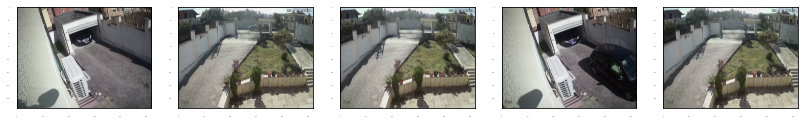

In [ ]:
%matplotlib inline

test_image_dir = '/content/'
# declare an empty list
test_images_np = []

# run a for loop for each image
for i in range(1, 6):

    # define the path (string) for each image
    image_path = os.path.join(test_image_dir+'car_detect_'+str(i)+'.jpg')

    # load images into numpy arrays and append to the list
    test_images_np.append(load_image_into_numpy_array(image_path))

# configure plot settings via rcParams
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# plot the images
for idx, test_image_np in enumerate(test_images_np):
  plt.subplot(1, 5, idx+1)
  plt.imshow(test_image_np)
  
plt.show()



### Preprocess, predict, and post process an image

Now let's define a function that returns the detection boxes, classes, and scores for an inferenced image.

In [ ]:
# decorator to run graph mode
@tf.function
def detect(input_t):
    """Run detection on an input image.

    Args:
    input_t: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_img, shapes = detection_model.preprocess(input_t)
    prediction_dict = detection_model.predict(preprocessed_img, shapes)
    
    # here we use the detection model's postprocess() method to get the the final detections
    detections = detection_model.postprocess(prediction_dict, shapes)
    
    return detections

Now we can loop through the test images and get the detection scores and bounding boxes to overlay in the original image. 

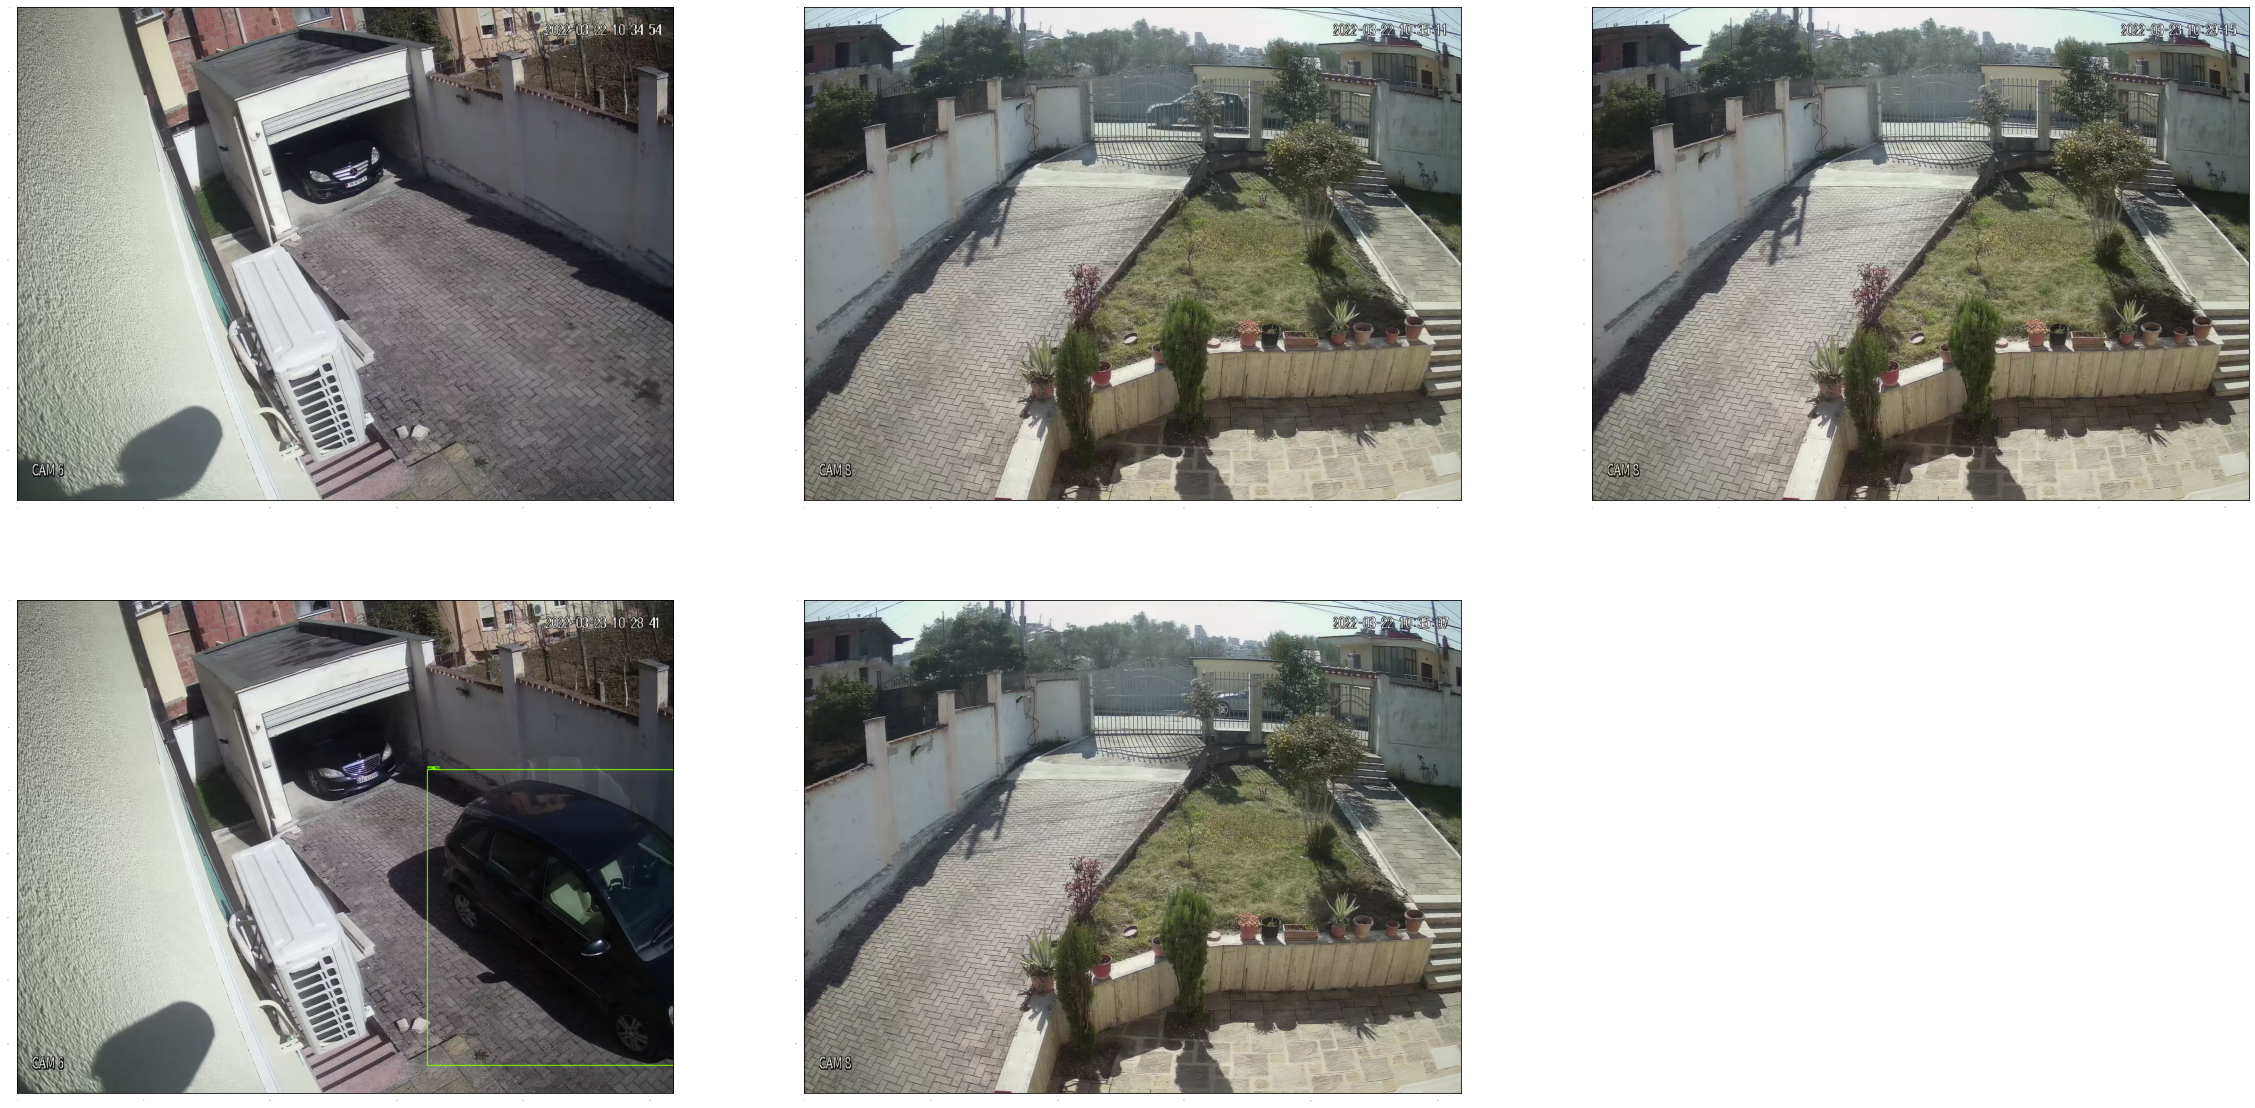

In [ ]:
#since our class id label starts at 1
label_id_offset = 1
results = {'boxes': [] , 'scores': []}
plt.figure(figsize=(40,20))

for idx in range(len(test_images_np)):
  #add a batch dimension and convert to tensor
  input_t = tf.expand_dims(tf.convert_to_tensor(
        test_images_np[idx], dtype=tf.float32), axis=0)

  detections = detect(input_t)

  plt.subplot(2, 3, idx+1)

  plot_detections(
      test_images_np[idx],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)+ label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index)

  results['boxes'].append(detections['detection_boxes'][0][0].numpy())
  results['scores'].append(detections['detection_scores'][0][0].numpy())
  
plt.show()

We can aslo check if the model detects a car class in the images by examining the `scores` key of the `results` dictionary.

In [ ]:
x = np.array(results['scores'])
#a list of the scores for each inferenced image
print(x)
# percent of frames where a car is detected
car_detected = (np.where(x > 0.5, 1, 0).sum())/5*100
print(car_detected)

[0.27920806 0.2395705  0.24006754 0.75083387 0.17450142]
20.0
